## Steps:

1. load and concatenate data
2. feature selection (Feature encoding if necessary)
3. benchmark ML
4. optimise

## Ideas in progress

Three key issues to solve: imbalanced classes, n < p, 9 distinct classification tasks

__Solutions__

- Feature selection - recursive, kbest, variance threshold

- PCA or other dimensionality reduction technique, to create new features

- Creating synthetic data to upsample set of active compounds - data augmentation - autoencoders?
If can augment data to suitably balance classes (by oversampling, autoencoders or otherwise), could then apply some DL algorithms for a protein. Then once features are learned, use transfer learning for other 8 proteins.
- Classifying all active and decoy compounds - every protein aggregated together. By looking at PCA/ variable importance plots, could try to identify features that are important across multiple proteins, and combine these into a master model.

## Read in data, aggregate into single dataframe for each protein, then store each in dict

In [141]:
import pandas as pd
import matplotlib.pylab as plt
import os
files = os.listdir()


## Get all protein names 
protein_names = [u.split('_')[0] for u in files if 'actives_rdkit_features.csv' in u]

all_proteins = {}
for protein in protein_names[0:1]:
    for file in files:
        if protein in file:
            tmp1 = pd.read_csv(protein+ '_actives_rdkit_features.csv')
            tmp1['ACTIVE'] = 1
            tmp2 = pd.read_csv(protein+'_decoys_rdkit_features.csv')
            ## Currently only sampling 500 from decoy set - massive downsampling
            #tmp2 = tmp2.sample(n=500)
            tmp2['ACTIVE'] = 0
            frames = [tmp1,tmp2]
            all_proteins[protein] = pd.concat(frames).reset_index(drop=True)


## Basic sklearn ML pipeline

In [145]:
## Data processing and train/test split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import roc_curve, auc

# get the protein of interest from the dict
df = all_proteins['mmp13']


# define X and y 
X = df.drop(['Unnamed: 0','ACTIVE'],axis=1)
y = all_proteins['mmp13']['ACTIVE']


x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=0)





### Logistic Regression

In [110]:
lr = LogisticRegression(random_state=0, solver='lbfgs').fit(x_train, y_train)
lr_pred = lr.predict(x_test)


# Generate confusion matrix
lr_confusion = confusion_matrix(y_test,lr_pred)


### Random Forests

AUROC = 0.93547107438


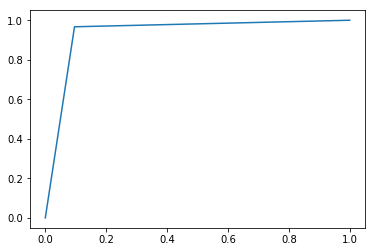

In [109]:
rf = RandomForestClassifier(n_estimators=500, max_depth=2,random_state=2)
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)

# Generate confusion matrix
rf_confusion = confusion_matrix(y_test,rf_pred)

# Generate roc curve to look at FP vs TP rate
fpr,tpr,threshold = roc_curve(y_test,rf_pred)
plt.plot(fpr,tpr)
roc_auc = auc(fpr, tpr)
print('AUROC = ' + str(roc_auc))



### Gradient boosting

AUROC = 0.959603305785


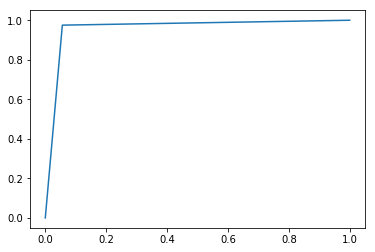

In [108]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()

gb.fit(x_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
 learning_rate=0.1, loss='deviance', max_depth=3,
 max_features=None, max_leaf_nodes=None,
 min_impurity_split=1e-07, min_samples_leaf=1,
 min_samples_split=2, min_weight_fraction_leaf=0.0,
 n_estimators=100, presort='auto', random_state=None,
 subsample=1.0, verbose=0, warm_start=False)

gb_pred = gb.predict(x_test)


# Generate confusion matrix
gb_confusion = confusion_matrix(y_test,gb_pred)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, gb_pred)
plt.plot(false_positive_rate,true_positive_rate)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('AUROC = ' + str(roc_auc))


## Data oversampling

In [178]:
## naive oversampling of the minority class


X = np.asarray(x_train)
y = np.asarray(y_train)

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

clf_resampled_svc = LinearSVC().fit(X_resampled, y_resampled)
svm_ros_pred = clf_resampled_svc.predict(x_test)

svm_confusion = confusion_matrix(y_test,svm_ros_pred)

# check resampling has worked
plt.hist(y_resampled)

[(0, 27836), (1, 27836)]


In [186]:
## Oversampling with SMOTE & ADASYN
from imblearn.over_sampling import SMOTE, ADASYN
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
clf_smote = RandomForestClassifier(n_estimators=500, max_depth=2,random_state=2)
clf_smote.fit(X_resampled, y_resampled)

X_resampled, y_resampled = ADASYN().fit_resample(X, y)
clf_adasyn = RandomForestClassifier(n_estimators=500, max_depth=2,random_state=2)
clf_adasyn.fit(X_resampled, y_resampled)

smote_rf = clf_smote.predict(x_test)
adasyn_rf = clf_adasyn.predict(x_test)


smote_confusion = confusion_matrix(y_test,smote_rf)
adasyn_confusion = confusion_matrix(y_test,adasyn_rf)

## Look at ROC curve with resampled data
fpr,tpr,threshold = roc_curve(y_test,smote_rf)
plt.plot(fpr,tpr)

AUROC = 0.929252880437


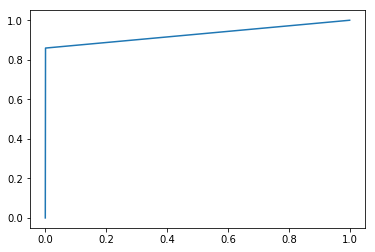

In [190]:
## Now compare to hyperparameter tuned GB on resampled data

gb = GradientBoostingClassifier()

gb.fit(X_resampled, y_resampled)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
 learning_rate=0.1, loss='deviance', max_depth=3,
 max_features=None, max_leaf_nodes=None,
 min_impurity_split=1e-07, min_samples_leaf=1,
 min_samples_split=2, min_weight_fraction_leaf=0.0,
 n_estimators=100, presort='auto', random_state=None,
 subsample=1.0, verbose=0, warm_start=False)

gb_pred = gb.predict(x_test)


# Generate confusion matrix
gb_confusion = confusion_matrix(y_test,gb_pred)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, gb_pred)
plt.plot(false_positive_rate,true_positive_rate)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('AUROC = ' + str(roc_auc))


In [123]:
## Trying to replicate plotting shown here: https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/over-sampling/plot_comparison_over_sampling.html#sphx-glr-auto-examples-over-sampling-plot-comparison-over-sampling-py

from collections import Counter
import numpy as np

from sklearn.datasets import make_classification
from sklearn.svm import LinearSVC

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, SMOTENC
from imblearn.over_sampling import RandomOverSampler
from imblearn.base import BaseSampler

def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')
    
def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    # make nice plotting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    return Counter(y_res)


ValueError: X has 2 features per sample; expecting 200

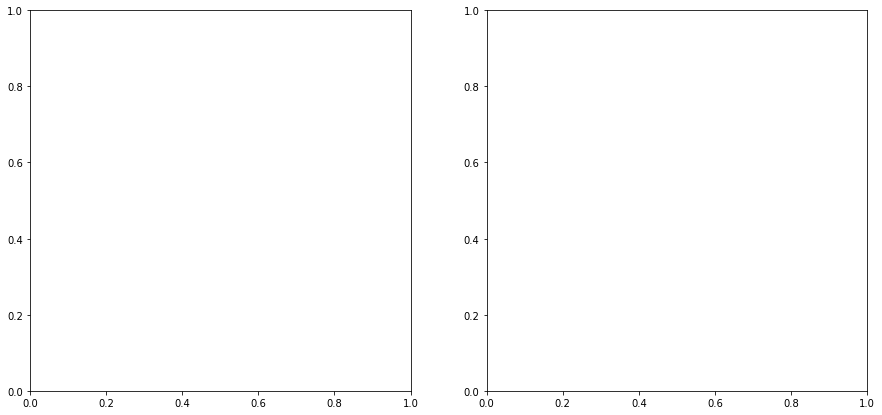

In [127]:
X = np.asarray(x_train)
y = np.asarray(y_train)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
# X, y = create_dataset(n_samples=10000, weights=(0.01, 0.05, 0.94))
clf = LinearSVC().fit(X, y)
plot_decision_function(X, y, clf, ax1)
ax1.set_title('Linear SVC with y={}'.format(Counter(y)))
pipe = make_pipeline(RandomOverSampler(random_state=0), LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax2)
ax2.set_title('Decision function for RandomOverSampler')
fig.tight_layout()


## Descriptive statistics

- Look at the number of compounds that are active for multiple proteins, and the number of compounds that are inactive against multiple compounds.